# Imbalanced Data dan Klasifikasi Data

Imbalanced data adalah kondisi ketika distribusi kelas dalam suatu dataset tidak seimbang, artinya jumlah sampel dari satu kelas jauh lebih banyak dibandingkan kelas lainnya. Misalnya, dalam dataset deteksi penipuan, data transaksi normal bisa mencapai 99%, sedangkan data penipuan hanya 1%.

Kondisi ini sering menjadi masalah dalam machine learning karena model cenderung bias terhadap kelas mayoritas. Akibatnya, meskipun akurasi terlihat tinggi, performa model dalam mengenali kelas minoritas (yang justru sering lebih penting) bisa sangat rendah.

## Install library yang digunakan

In [25]:
!pip install pymysql
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np
import pandas as pd

## Mengambil Data E-Coli dalam Database Mysql

In [26]:
import pymysql

# koneksi ke database mysql melalui aiven.io
DB_HOST = "mysql-131f3e28-fathanlearn-5ad0.i.aivencloud.com"
DB_PORT = 25962
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_hCKUXEhLqojSjCxujVo"

conn = pymysql.connect(
    host=DB_HOST,
    port=DB_PORT,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASS,
    ssl={'ssl': {}}
)

data_mysql = conn.cursor()

# ambil data ke database
data_mysql.execute("SELECT * FROM ecoli.data_ecoli;")
data = data_mysql.fetchall()


print("10 data dalam tabel ecoli: ")
for i in range(10):
  print(data[i])

10 data dalam tabel ecoli: 
('AAS_ECOLI', Decimal('0.44'), Decimal('0.52'), Decimal('0.48'), Decimal('0.50'), Decimal('0.43'), Decimal('0.47'), Decimal('0.54'), 'im')
('AAT_ECOLI', Decimal('0.49'), Decimal('0.29'), Decimal('0.48'), Decimal('0.50'), Decimal('0.56'), Decimal('0.24'), Decimal('0.35'), 'cp')
('ACEA_ECOLI', Decimal('0.07'), Decimal('0.40'), Decimal('0.48'), Decimal('0.50'), Decimal('0.54'), Decimal('0.35'), Decimal('0.44'), 'cp')
('ACEK_ECOLI', Decimal('0.56'), Decimal('0.40'), Decimal('0.48'), Decimal('0.50'), Decimal('0.49'), Decimal('0.37'), Decimal('0.46'), 'cp')
('ACKA_ECOLI', Decimal('0.59'), Decimal('0.49'), Decimal('0.48'), Decimal('0.50'), Decimal('0.52'), Decimal('0.45'), Decimal('0.36'), 'cp')
('ADI_ECOLI', Decimal('0.23'), Decimal('0.32'), Decimal('0.48'), Decimal('0.50'), Decimal('0.55'), Decimal('0.25'), Decimal('0.35'), 'cp')
('AGP_ECOLI', Decimal('0.74'), Decimal('0.49'), Decimal('0.48'), Decimal('0.50'), Decimal('0.42'), Decimal('0.54'), Decimal('0.36'), 'p

## Transformasi Data dalam Bentuk 2 Dimensi menggunakan PCA

Principal Component Analysis (PCA) adalah teknik dimensionality reduction yang digunakan untuk mengubah data berdimensi tinggi menjadi dimensi yang lebih rendah, dengan tetap mempertahankan sebanyak mungkin informasi penting dari data.

Proses PCA melibatkan transformasi data asli ke dalam komponen utama (principal components), yaitu kombinasi linier dari variabel-variabel awal. Komponen utama ini dipilih berdasarkan varian data terbesar, sehingga pola utama dalam data dapat tetap terjaga meskipun jumlah dimensinya berkurang.



Langkah-Langkah PCA dalam mereduksi data:
1. Standarisasi data → menyamakan skala tiap fitur.
2. Membentuk matriks kovarians → untuk melihat hubungan antar variabel.
3. Menghitung eigenvalue & eigenvector → menentukan arah dan besarnya variasi data.
4. Menyusun principal components → memilih komponen dengan eigenvalue terbesar.
5. Transformasi data → memproyeksikan data asli ke sumbu baru (principal components).

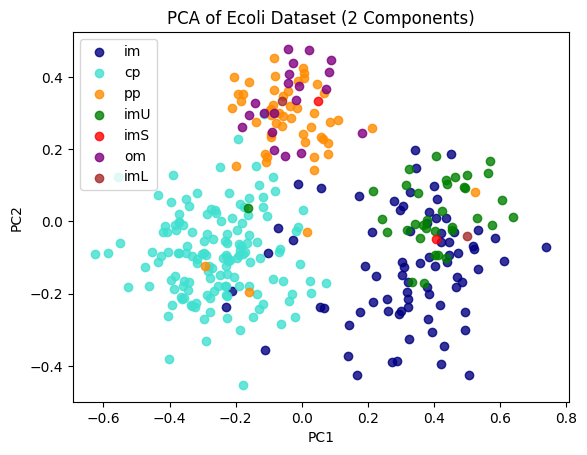

In [27]:
# meload data yang telah diambil dari database
df_data = pd.DataFrame(data, columns=["id_ecoli", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"])
# seleksi data non id dan class
X = df_data.drop(columns=["class", "id_ecoli"])
# ambil data class
y = df_data["class"]

# pembuatan model pca dengan 2 dimensi
pca = PCA(n_components=2)
# proses training
X_r = pca.fit(X).transform(X)

# mengubah data hasil train ke dataframe dan disimpan dalam dua kolom
df_pca = pd.DataFrame(X_r, columns=["PC1", "PC2"])
df_pca["class"] = y.values

# membuat kanvas
plt.figure()
colors = ["navy", "turquoise", "darkorange", "green", "red", "purple", "brown"]

# perulangan untuk setiap data dalam class
for color, target_name in zip(colors, df_pca["class"].unique()):
    # matching class data dengan class iterasi saat ini
    subset = df_pca[df_pca["class"] == target_name]
    # proses plotting data menggunakan scatter
    plt.scatter(subset["PC1"], subset["PC2"], alpha=0.8, color=color, label=target_name)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Ecoli Dataset (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Cara Mengetahui Total data dalam Setiap CLass

In [28]:
print("Total data dalam setiap class: ")
# library counter untuk menghitung jumlah data dalam suatu class
print(Counter(y))

Total data dalam setiap class: 
Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})


Berdasarkan output di atas dapat disimpulkan bahwa beberapa class memiliki imbalance data yakni class oml, ims, dan iml. Dengan begitu, diperlukan Balancing data menggunakan beberapa metode seperti SMOTE dan ADASYN.

## Balancing data menggunakan SMOTE

SMOTE adalah metode oversampling yang digunakan untuk mengatasi masalah imbalanced data, yaitu ketika jumlah sampel pada kelas minoritas jauh lebih sedikit dibandingkan kelas mayoritas.

Berbeda dengan oversampling biasa (sekedar menggandakan data minoritas), SMOTE membuat data sintetis baru untuk kelas minoritas dengan cara menginterpolasi antara sampel yang ada. Dengan demikian, dataset menjadi lebih seimbang tanpa sekedar menduplikasi data.

Langkah-Langkah Balancing data menggunakan SMOTE:
1. Identifikasi satu titik dari kelas minoritas.
2. Tentukan k tetangga terdekat.
3. Buat data sintetik diantara titik dan tetangga tersebut.
4. Ulangi 1 sampai 3 untuk seluruh titik titik minoritas.

In [29]:
from imblearn.over_sampling import SMOTE

# Jumlah data dalam class sebelum proses SMOTE
print("Sebelum SMOTE:", Counter(y))

# membuat model SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)

# proses training atau resampling
X_resampling, y_resampling = smote.fit_resample(X, y)

#  Jumlah data dalam class sesudah proses SMOTE
print("Sesudah SMOTE:", Counter(y_resampling))


Sebelum SMOTE: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Sesudah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


### Grafik Batang Persebaran Data Balancing SMOTE

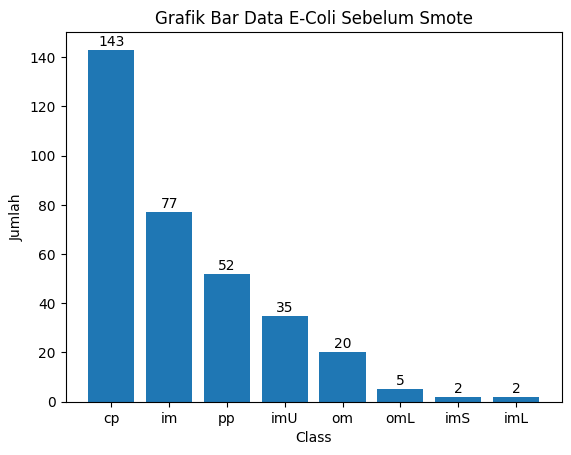

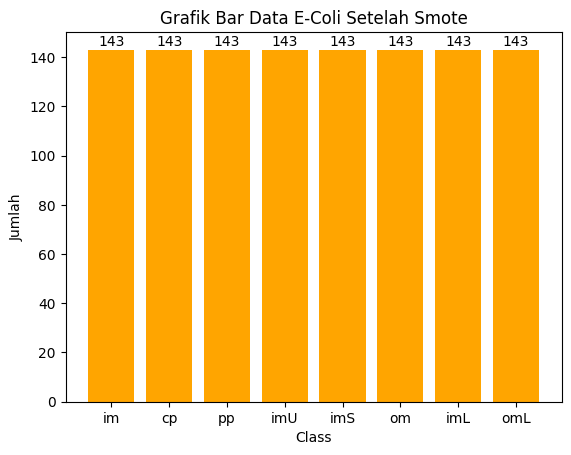

In [30]:
# Data sebelum smote
data_sebelum_SMOTE = Counter(y)
sorted_items = sorted(data_sebelum_SMOTE.items(), key=lambda x: x[1], reverse=True)
label_SMOTE = [item[0] for item in sorted_items]
jumlah_sebelum_smote = [item[1] for item in sorted_items]

# Membuat grafik batang
plt.bar(label_SMOTE, jumlah_sebelum_smote)

# Menambahkan label angka di atas batang
for i, val in enumerate(jumlah_sebelum_smote):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom')

# Judul dan label sumbu
plt.title("Grafik Bar Data E-Coli Sebelum Smote")
plt.xlabel("Class")
plt.ylabel("Jumlah")

plt.show()

# Data Setelah SMOTE
data_setelah_SMOTE = Counter(y_resampling)
sorted_items_after = sorted(data_setelah_SMOTE.items(), key=lambda x: x[1], reverse=True)
label_SMOTE = [item_res[0] for item_res in sorted_items_after]
jumlah_setelah_smote = [item_res[1] for item_res in sorted_items_after]

# Membuat grafik batang
plt.bar(label_SMOTE, jumlah_setelah_smote, color='orange')

# Menambahkan label angka di atas batang
for i, val in enumerate(jumlah_setelah_smote):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom')

# Judul dan label sumbu
plt.title("Grafik Bar Data E-Coli Setelah Smote")
plt.xlabel("Class")
plt.ylabel("Jumlah")


plt.show()


## Balancing Data menggunakan ADASYN

ADASYN adalah teknik oversampling yang dikembangkan untuk mengatasi imbalanced data, mirip seperti SMOTE, namun dengan pendekatan yang lebih adaptif.

Tujuan ADASYN adalah menghasilkan sampel sintetis untuk kelas minoritas, tetapi fokus pada contoh yang lebih sulit dipelajari (hard-to-learn samples). Artinya, data minoritas yang berada di dekat kelas mayoritas akan mendapatkan lebih banyak sampel sintetis dibandingkan yang sudah mudah diprediksi.

Langkah-Langkah Balancing data menggunakan ADASYN:
1. Hitung k-nearest neighbors (KNN) untuk setiap sampel minoritas.

2. Tentukan kesulitan belajar setiap sampel minoritas berdasarkan jumlah tetangga mayoritas di sekitarnya.

3. Buat sampel sintetis proporsional dengan tingkat kesulitan:

  - Sampel minoritas yang sulit dipelajari → lebih banyak sampel sintetis

  - Sampel minoritas yang mudah dipelajari → lebih sedikit sampel sintetis

In [31]:
from imblearn.over_sampling import ADASYN

# Jumlah data dalam class # sebelum proses ADASYN
print("Sebelum ADASYN:", Counter(y))

# Copy data utuk fitur dan class
X_res_adasyn, y_res_adasyn = X.copy(), y.copy()

# ambil jumlah sampel per kelas
class_counts = Counter(y)

for cls, count in class_counts.items():
  # hanya resample kelas minor
    if count < max(class_counts.values()):
      # pemberaian nilai k otommatis berdasarkan jumlah data
        k = max(1, min(5, count - 1))
        print(f"Kelas {cls}: jumlah={count}, menggunakan n_neighbors={k}")
        # pembuatan model ADASYN
        adasyn = ADASYN(random_state=42, sampling_strategy={cls: max(class_counts.values())}, n_neighbors=k)
        # proses training ADASYN
        X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_res_adasyn, y_res_adasyn)

print("Sesudah ADASYN:", Counter(y_res_adasyn))


Sebelum ADASYN: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Kelas im: jumlah=77, menggunakan n_neighbors=5
Kelas pp: jumlah=52, menggunakan n_neighbors=5
Kelas imU: jumlah=35, menggunakan n_neighbors=5
Kelas imS: jumlah=2, menggunakan n_neighbors=1
Kelas om: jumlah=20, menggunakan n_neighbors=5
Kelas imL: jumlah=2, menggunakan n_neighbors=1
Kelas omL: jumlah=5, menggunakan n_neighbors=4
Sesudah ADASYN: Counter({'im': 156, 'pp': 150, 'cp': 143, 'imU': 143, 'om': 143, 'omL': 143, 'imS': 142, 'imL': 142})


### Grafik Batang Persebaran Data Balancing ADASYN

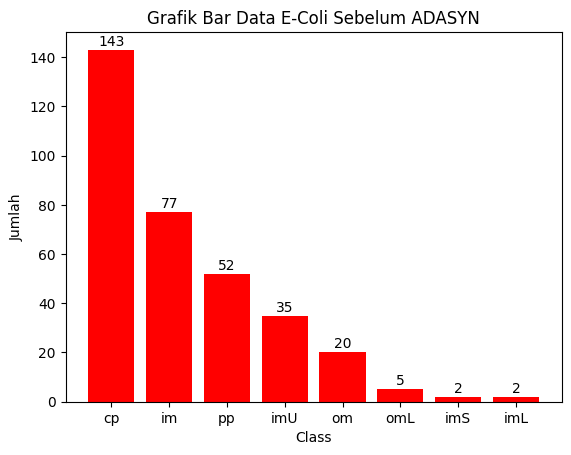

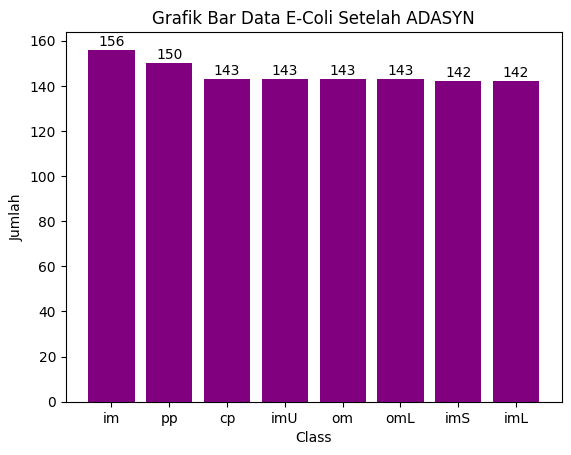

In [32]:
# Data sebelum smote
data_sebelum_ASD = Counter(y)
sorted_items = sorted(data_sebelum_ASD.items(), key=lambda x: x[1], reverse=True)
label_ASD = [item[0] for item in sorted_items]
jumlah_sebelum_ASD = [item[1] for item in sorted_items]

# Membuat grafik batang
plt.bar(label_ASD, jumlah_sebelum_ASD, color="red")

# Menambahkan label angka di atas batang
for i, val in enumerate(jumlah_sebelum_ASD):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom')

# Judul dan label sumbu
plt.title("Grafik Bar Data E-Coli Sebelum ADASYN")
plt.xlabel("Class")
plt.ylabel("Jumlah")

plt.show()

# Data Setelah SMOTE
data_setelah_asd = Counter(y_res_adasyn)
sorted_items_after_asd = sorted(data_setelah_asd.items(), key=lambda x: x[1], reverse=True)
label_ASD = [item_res[0] for item_res in sorted_items_after_asd]
jumlah_setelah_asd = [item_res[1] for item_res in sorted_items_after_asd]

# Membuat grafik batang
plt.bar(label_ASD, jumlah_setelah_asd, color='purple')

# Menambahkan label angka di atas batang
for i, val in enumerate(jumlah_setelah_asd):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom')

# Judul dan label sumbu
plt.title("Grafik Bar Data E-Coli Setelah ADASYN")
plt.xlabel("Class")
plt.ylabel("Jumlah")


plt.show()


## Ploting Data Setelah Proses SMOTE menggunakan PCA

Jumlah data asli: 336
Jumlah data setelah SMOTE: 1144
Jumlah data hasil generate: 808


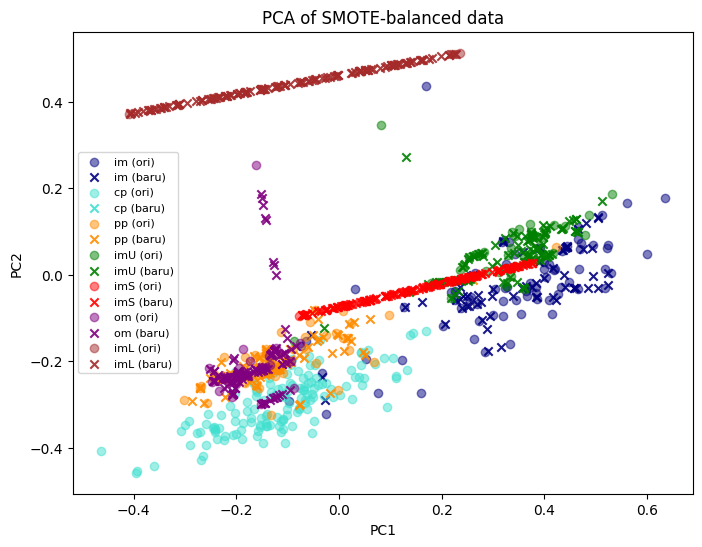

In [33]:
n_asli = len(X)
n_baru = len(X_resampling)

print("Jumlah data asli:", n_asli)
print("Jumlah data setelah SMOTE:", n_baru)
print("Jumlah data hasil generate:", n_baru - n_asli)


# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampling)

# ubah ke dataframe
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = y_resampling

# tambahkan flag: asli / baru
df_pca["source"] = "original"
df_pca.loc[n_asli:, "source"] = "baru"

# plotting
plt.figure(figsize=(8,6))
colors = ["navy", "turquoise", "darkorange", "green", "red", "purple", "brown"]

for color, target_name in zip(colors, df_pca["class"].unique()):
    subset = df_pca[df_pca["class"] == target_name]

    # plot data asli
    plt.scatter(subset[subset["source"]=="original"]["PC1"],
                subset[subset["source"]=="original"]["PC2"],
                alpha=0.5, color=color, label=f"{target_name} (ori)")

    # plot data baru
    plt.scatter(subset[subset["source"]=="baru"]["PC1"],
                subset[subset["source"]=="baru"]["PC2"],
                alpha=0.9, color=color, marker="x", label=f"{target_name} (baru)")

plt.legend(loc="best", fontsize=8)
plt.title("PCA of SMOTE-balanced data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Ploting Data Setelah Proses ADASYN menggunakan PCA

Jumlah data asli: 336
Jumlah data setelah ADASYN: 1162
Jumlah data hasil generate: 826


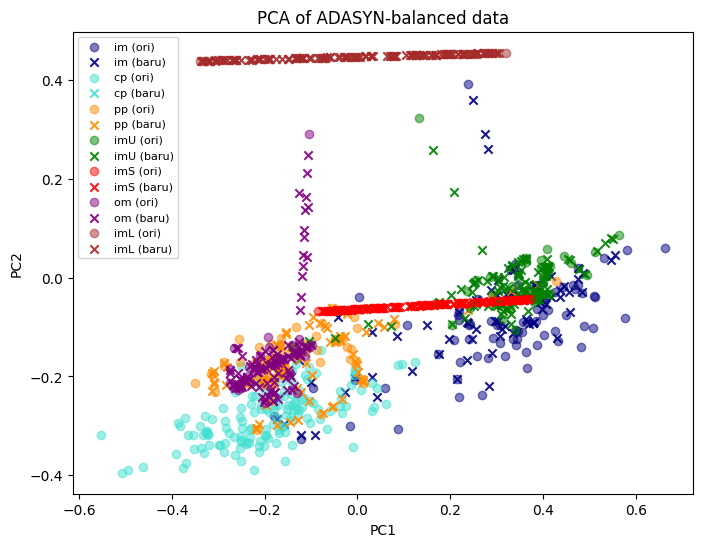

In [34]:
n_asli = len(X)
n_baru = len(X_res_adasyn)

print("Jumlah data asli:", n_asli)
print("Jumlah data setelah ADASYN:", n_baru)
print("Jumlah data hasil generate:", n_baru - n_asli)


# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res_adasyn)

# ubah ke dataframe
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = y_res_adasyn

# tambahkan flag: asli / baru
df_pca["source"] = "original"
df_pca.loc[n_asli:, "source"] = "baru"

# plotting
plt.figure(figsize=(8,6))
colors = ["navy", "turquoise", "darkorange", "green", "red", "purple", "brown"]

for color, target_name in zip(colors, df_pca["class"].unique()):
    subset = df_pca[df_pca["class"] == target_name]

    # plot data asli
    plt.scatter(subset[subset["source"]=="original"]["PC1"],
                subset[subset["source"]=="original"]["PC2"],
                alpha=0.5, color=color, label=f"{target_name} (ori)")

    # plot data baru
    plt.scatter(subset[subset["source"]=="baru"]["PC1"],
                subset[subset["source"]=="baru"]["PC2"],
                alpha=0.9, color=color, marker="x", label=f"{target_name} (baru)")

plt.legend(loc="best", fontsize=8)
plt.title("PCA of ADASYN-balanced data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Klasifikasi Menggunakan Naive Bayes

**Naive Bayes** adalah salah satu metode klasifikasi yang sederhana namun sangat efektif dalam dunia pembelajaran mesin (machine learning). Metode ini bekerja berdasarkan prinsip probabilitas, khususnya Teorema Bayes, yang digunakan untuk memperkirakan kemungkinan suatu data termasuk ke dalam sebuah kelas tertentu.

Ciri khas dari metode ini adalah anggapan bahwa setiap fitur (atau atribut) pada data bersifat saling independen, artinya kemunculan satu fitur tidak dipengaruhi oleh fitur lainnya. Meskipun anggapan ini sering kali tidak sepenuhnya benar dalam kenyataan, pendekatan “naive” ini justru membuat perhitungan menjadi lebih sederhana dan efisien, serta tetap menghasilkan performa yang kompetitif dalam banyak kasus.


Teorema Bayes:

$$
P(C \mid X) = \frac{P(X \mid C) \cdot P(C)}{P(X)}
$$


Keterangan:
- $( P(C \mid X) $): **Posterior** – probabilitas kelas $( C $) diberikan data $( X $)
- $( P(X \mid C) $): **Likelihood** – probabilitas data $( X $) muncul jika kelasnya \( C \)
- $( P(C) $): **Prior** – probabilitas awal kelas $( C $) sebelum melihat data
- $( P(X) $): Probabilitas keseluruhan data $( X $) (konstanta untuk semua kelas)

Langkah - Langkah Pada Modelling:

1. Pada saat Training Model akan membagi dataset menjadi dua bagian yakni 30% datset yang digunakan untuk testing dan 70% data digunakan untuk training.
2. Menghitung Probabilitas Awal
3. Menghitung Persebaran data / Standar Deviasi.
4. Menghitung Distribusi Gaussian.
5. Menghitung Posterior.

In [35]:
# Library yang digunakan
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

### Data Ecoli Asli (Sebelum mendapatkan Balancing)

In [36]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# instance model
gnb = GaussianNB()
# train data
train_gnb = gnb.fit(X_train, y_train)
# predict data
y_pred_gnb = gnb.predict(X_test)
# hitung akurasi
acc_gnb = accuracy_score(y_test, y_pred_gnb)

print(f"nilai akurasi sebelum balancing : {acc_gnb:.2f}")

nilai akurasi sebelum balancing : 0.80


### Data Ecoli Asli (Setelah mendapatkan Balancing SMOTE)

In [37]:
# split data
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampling, y_resampling, test_size=0.3, random_state=0)
# instance model
gnb_smote = GaussianNB()
# train data
train_gnb_smote = gnb_smote.fit(X_train_smote, y_train_smote)
# predict data
y_pred_gnb_smote = gnb_smote.predict(X_test_smote)
# hitung akurasi
acc_gnb_smote = accuracy_score(y_test_smote, y_pred_gnb_smote)

print(f"nilai akurasi setelah balancing SMOTE : {acc_gnb_smote:.2f}")

nilai akurasi setelah balancing SMOTE : 0.85


### Data Ecoli Asli (Setelah mendapatkan Balancing ADASYN)

In [38]:
# split data
X_train_ads, X_test_ads, y_train_ads, y_test_ads = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=0)
# instance model
gnb_asdasyn = GaussianNB()
# train data
train_gnb_asd = gnb_asdasyn.fit(X_train_ads, y_train_ads)
# predict data
y_pred_gnb_ads = gnb_asdasyn.predict(X_test_ads)
# hitung akurasi
acc_gnb_ads = accuracy_score(y_test_ads, y_pred_gnb_ads)

print(f"nilai akurasi setelah balancing ADASYN : {acc_gnb_ads:.2f}")

nilai akurasi setelah balancing ADASYN : 0.78


Berdasarkan hasil percobaan pembuatan model klasifikasi menggunakan Gaussian Naive Bayes dari ketiga data yakni data asli sebelum proses balancing, data setelah balancing menggunakan SMOTE, dan data setelah Balancing menggunakan ADASYN diperoleh hasil akurasi seperti berikut:

- Naive Bayes Data Asli : 80%
- Naive Bayes Data Balancing SMOTE : 85%
- Naive Bayes Data Balancing ADASYN : 78%

Dapat disimpulkan bahwa klasifikasi menggunakan Gaussian Naive Bayes pada data Balancing menggunakan SMOTE cenderung lebih baik dalam pengklasifikasian data yakni sebesar 80%.

## Klasifikasi Menggunakan Random Forest

**Random Forest Classifier** adalah sebuah metode klasifikasi yang bekerja dengan menggabungkan banyak pohon keputusan. Setiap pohon dibangun dari potongan data yang berbeda, lalu masing-masing pohon memberikan prediksi terhadap suatu sampel. Prediksi akhir ditentukan berdasarkan hasil voting dari semua pohon, sehingga kelas yang paling banyak dipilih menjadi keputusan model.

Karena mengandalkan banyak pohon sekaligus, Random Forest lebih stabil dan akurat dibanding hanya menggunakan satu pohon keputusan saja. Metode ini mampu mengurangi risiko overfitting, menangani data dengan banyak fitur, serta memberikan informasi mengenai fitur mana yang paling berpengaruh dalam proses klasifikasi. Namun, di sisi lain, Random Forest cenderung lebih lambat dalam pelatihan dan sulit untuk diinterpretasikan karena kompleksitasnya yang tinggi.

---

**Rumus Dasar Voting**

Jika terdapat $( B $) pohon keputusan $( h_b(x) $), maka prediksi akhir adalah:

$$
\hat{y} = \mathrm{mode}\{h_1(x), h_2(x), \dots, h_B(x)\}
$$

Keterangan:
- $( h_b(x) $): prediksi pohon ke-$( b $)  
- $( B $): jumlah total pohon  
- $( \hat{y} $): hasil akhir (kelas mayoritas)

---

**Kriteria Pemisahan (Impurity Measure)**

Untuk memilih split terbaik, digunakan ukuran ketidakmurnian (impurity). Dua yang paling umum:

1. **Gini Index**

$$
Gini(S) = 1 - \sum_{k=1}^{K} p_k^2
$$

2. **Entropy**

$$
Entropy(S) = - \sum_{k=1}^{K} p_k \log_2(p_k)
$$

dengan $( p_k $) adalah proporsi kelas $( k $) dalam node $( S $).

---

**Langkah - Langkah Pada Modelling:**

1. **Membagi Dataset**  
   Biasanya dataset dibagi menjadi 70% untuk *training* dan 30% untuk *testing*.  

2. **Bootstrap Sampling**  
   Dari data *training*, dibuat beberapa subset data dengan pengambilan acak **dengan pengembalian**.  

3. **Bangun Pohon Keputusan**  
   Setiap subset data digunakan untuk membangun satu *Decision Tree*, dengan pemilihan fitur secara acak di tiap node.  

4. **Lakukan Prediksi Voting**  
   Masing-masing pohon memberikan prediksi, lalu hasil akhir ditentukan dengan **mayoritas suara** (*majority vote*).  

5. **Evaluasi Model**  
   Bandingkan prediksi $(\hat{y}$) dengan label sebenarnya menggunakan metrik evaluasi (misalnya *accuracy*).  

---

In [39]:
# library yang digunakan
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Data Ecoli Asli (Sebelum mendapatkan Balancing)

In [40]:
# split data (train & test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# buat model Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# train data
rf.fit(X_train, y_train)

# predict data
y_pred = rf.predict(X_test)

# hitung akurasi
acc_rf = accuracy_score(y_test, y_pred)
print(f"nilai akurasi sebelum balancing: {acc_rf:.2f}")


nilai akurasi sebelum balancing: 0.87


### Data Ecoli Asli (Setelah mendapatkan Balancing SMOTE)

In [41]:
# split data (train & test)
X_train_rf_smote, X_test_rf_smote, y_train_rf_smote, y_test_rf_smote = train_test_split(X_resampling, y_resampling, test_size=0.3, random_state=42)

# buat model Random Forest
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# train data
rf_smote.fit(X_train_rf_smote, y_train_rf_smote)

# predict data
y_pred_rf_smote = rf_smote.predict(X_test_rf_smote)

# hitung akurasi
acc_rf_smote = accuracy_score(y_test_rf_smote, y_pred_rf_smote)
print(f"nilai akurasi sebelum balancing: {acc_rf_smote:.2f}")


nilai akurasi sebelum balancing: 0.95


### Data Ecoli Asli (Setelah mendapatkan Balancing ADASYN)

In [42]:
# split data (train & test)
X_train_rf_ads, X_test_rf_ads, y_train_rf_ads, y_test_rf_ads = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=42)

# buat model Random Forest
rf_adasyn = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# train data
rf_adasyn.fit(X_train_rf_ads, y_train_rf_ads)

# predict data
y_pred_rf_adasyn = rf_adasyn.predict(X_test_rf_ads)

# hitung akurasi
acc_rf_adasyn = accuracy_score(y_test_rf_ads, y_pred_rf_adasyn)
print(f"nilai akurasi sebelum balancing: {acc_rf_adasyn:.2f}")


nilai akurasi sebelum balancing: 0.93


Berdasarkan hasil percobaan pembuatan model klasifikasi menggunakan Random Forest dari ketiga data yakni data asli sebelum proses balancing, data setelah balancing menggunakan SMOTE, dan data setelah Balancing menggunakan ADASYN diperoleh hasil akurasi seperti berikut:

- Naive Bayes Data Asli : 87%
- Naive Bayes Data Balancing SMOTE : 95%
- Naive Bayes Data Balancing ADASYN : 93%

Dapat disimpulkan bahwa klasifikasi menggunakan Random Forest pada data Balancing menggunakan SMOTE cenderung lebih baik dalam pengklasifikasian data yakni sebesar 95%.

## Bagging Classifier

Bagging Classifier merupakan meta estimator ansambel yang cara kerjanya menempatkan pengklasifikasian model dasar pada subset yang acak dari dataset asli, kemudian menggabungkan prediksi individualnya (baik melalui pemungutan suara maupun dengan merata-ratakan) untuk membentuk prediksi akhir. Meta Estimator seperti ini biasanya digunakan sebagai suatu cara untuk mengurangi varian estimator kotak hitam dengan cara memasukkan pengacakan melalui prosedir konstruksi dan menjadikannya sebuah ansambel.

### Bagging Classifier Menggunakan Model Naive Bayes

In [43]:
# Library yanag digunakan
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

#### Bagging Classifier Naive Bayes pada Data Hasil Balanced SMOTE

In [51]:
# split data training dan testing
X_train_ensamble_bg, X_test_ensamble_bg, y_train_ensamble_bg, y_test_ensamble_bg = train_test_split(X_resampling, y_resampling, test_size=0.3, random_state=0)
# instance model
clf = BaggingClassifier(estimator=GaussianNB(),
                        n_estimators=100, random_state=0).fit(X_train_ensamble_bg, y_train_ensamble_bg)
# prediksi hasil klasifikasi
predict_ensamble_smote = clf.predict(X_test_ensamble_bg)

# perhitungan nilai akurasi
acc_ensamble_smote = accuracy_score(y_test_ensamble_bg, predict_ensamble_smote)
print(f"hasil akurasi setelah proses ensamble: {acc_ensamble_smote:.2f}")


hasil akurasi setelah proses ensamble: 0.86


#### Bagging Classifier Naive Bayes pada Data Hasil Balanced ADASYN

In [54]:
# split data training dan testing
X_train_bg_ads, X_test_bg_ads, y_train_bg_ads, y_test_bg_ads = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=0)
# instance model
clf_adasyn = BaggingClassifier(estimator=GaussianNB(),
                        n_estimators=100, random_state=0).fit(X_train_bg_ads, y_train_bg_ads)
# prediksi hasil klasifikasi
predict_ensamble_ads = clf_adasyn.predict(X_test_bg_ads)

# perhitungan nilai akurasi
acc_ensamble_ads = accuracy_score(y_test_bg_ads, predict_ensamble_ads)
print(f"hasil akurasi setelah proses ensamble: {acc_ensamble_ads:.2f}")


hasil akurasi setelah proses ensamble: 0.78


Berdasarkan hasil proses traing menggunakan model Bagging Classifier Naive Bayes pada data hasil balancing menggunakan metode SMOTE dan ADASYN menunjukkan nilai akurasi yang cukup tinggi. Berikut hasil akurasi setiap data balancing SMOTE dan ADSYN:

- Akurasi Bagging pada data Balancing SMOTE : 86%
- Akurasi Bagging pada data Balancing SMOTE : 78%

Dapat disimpulkan bahwa balancing menggunakan SMOTE memiliki nilai akurasi yang lebih tinggi dari ADSYN dengan menggunakan metode klasifikasi Bagging Naive Bayes.

### Bagging Classifier Menggunakan Model Random Forest

In [56]:
# Library yang dibutuhkan
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

#### Bagging Classifier Random Forest pada Data Hasil Balanced SMOTE

In [57]:
# split data training dan testing
X_train_ensemble_rf, X_test_ensemble_rf, y_train_ensemble_rf, y_test_ensemble_rf = train_test_split(X_resampling, y_resampling, test_size=0.3, random_state=0)
# instance model
clf_rf_bg_smote = BaggingClassifier(estimator=RandomForestClassifier(),
                        n_estimators=100, random_state=0).fit(X_train_ensemble_rf, y_train_ensemble_rf)
# prediksi hasil klasifikasi
predict_rf_bg = clf_rf_bg_smote.predict(X_test_ensemble_rf)

# perhitungan nilai akurasi
acc_ensamble_rf_smote = accuracy_score(y_test_ensemble_rf, predict_rf_bg)
print(f"hasil akurasi setelah proses ensamble: {acc_ensamble_rf_smote:.2f}")


hasil akurasi setelah proses ensamble: 0.97


#### Bagging Classifier Random Forest pada Data Hasil Balanced ADASYN

In [58]:
# split data training dan testing
X_train_ensemble_rf_ads, X_test_ensemble_rf_ads, y_train_ensemble_rf_ads, y_test_ensemble_rf_ads = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=0)
# instance model
clf_rf_bg_adasyn = BaggingClassifier(estimator=RandomForestClassifier(),
                        n_estimators=100, random_state=0).fit(X_train_ensemble_rf_ads, y_train_ensemble_rf_ads)
# prediksi hasil klasifikasi
predict_rf_bg_ads = clf_rf_bg_adasyn.predict(X_test_ensemble_rf_ads)

# perhitungan nilai akurasi
acc_ensamble_rf_adasyn = accuracy_score(y_test_ensemble_rf_ads, predict_rf_bg_ads)
print(f"hasil akurasi setelah proses ensamble: {acc_ensamble_rf_adasyn:.2f}")


hasil akurasi setelah proses ensamble: 0.95


Berdasarkan hasil proses traing menggunakan model Bagging Classifier Random Forest pada data hasil balancing menggunakan metode SMOTE dan ADASYN menunjukkan nilai akurasi yang cukup tinggi. Berikut hasil akurasi setiap data balancing SMOTE dan ADSYN:

- Akurasi Bagging pada data Balancing SMOTE : 97%
- Akurasi Bagging pada data Balancing SMOTE : 95%

Dapat disimpulkan bahwa balancing menggunakan SMOTE memiliki nilai akurasi yang lebih tinggi dari ADSYN dengan menggunakan metode klasifikasi Bagging Random Forest.